# Import Library and Load Dataset

In [ ]:
# ==========================
# Standard Libraries
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import joblib
import warnings
from collections import Counter
warnings.filterwarnings("ignore", category=UserWarning)

# ==========================
# Scikit-learn Utilities
# ==========================
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, label_binarize
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# ==========================
# Machine Learning Models
# ==========================
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier

# ==========================
# Evaluation Metrics
# ==========================
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, mean_squared_error, r2_score, roc_auc_score

# ==========================
# Imbalanced Data Handling
# ==========================
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek


subjects = [
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT",
    "SOFTWARE CONSTRUCTION AND CONFIGURATION", "WIRELESS APPLICATION DEVELOPMENT",
    "ADVANCED WEB APPLICATION DEVELOPMENT", "SOFTWARE QUALITY ASSURANCE",
    "SOFTWARE ENTREPRENEURSHIP", "PROJECT", "MULTIMEDIA TECHNOLOGY",
    "ARTIFICIAL INTELLIGENCE", "TEAM PROJECT", "PROGRAMMING WITH GAME ENGINES",
    "ADVANCED DATABASE SYSTEMS", "CLOUD COMPUTING", "DIGITAL IMAGE PROCESSING",
    "FUNDAMENTALS OF CYBERSECURITY", "PARALLEL PROCESSING", "DATA MINING",
    "TCP/IP NETWORK ROUTING", "SERVER CONFIGURATION AND MANAGEMENT",
    "TCP/IP NETWORK APPLICATION DEVELOPMENT", "NETWORK SECURITY MANAGEMENT"
]

columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT",
    "SOFTWARE CONSTRUCTION AND CONFIGURATION", "WIRELESS APPLICATION DEVELOPMENT",
    "ADVANCED WEB APPLICATION DEVELOPMENT", "SOFTWARE QUALITY ASSURANCE",
    "SOFTWARE ENTREPRENEURSHIP", "PROJECT"]

df_dir = "/content/training-data-1000.csv"
df_real_dir = "/content/real-data.csv"

df_real = pd.read_csv(df_real_dir)
df = pd.read_csv(df_dir)

grade_map = {"A+": 8, "A": 7, "A-": 6, "B+": 5, "B": 4, "B-": 3, "C+": 2, "C": 1, "F": 0}
df_real.replace(grade_map, inplace=True)
df_real = df_real.infer_objects(copy=False)
df.replace(grade_map, inplace=True)
df = df.infer_objects(copy=False)

<ipython-input-6-da5fbad1ed7b>:82: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_real.replace(grade_map, inplace=True)
<ipython-input-6-da5fbad1ed7b>:84: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(grade_map, inplace=True)


# CGPA

In [ ]:
# Drop rows with missing CGPA
df_cleaned = df.dropna(subset=["CGPA"])

# Separate features and target
X = df_cleaned.drop(columns=["CGPA"])
y = df_cleaned["CGPA"]

# Identify column types
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ("num", SimpleImputer(strategy="mean"), numerical_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_cols)
])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Combine feature names
feature_names_num = numerical_cols
feature_names_cat = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([feature_names_num, feature_names_cat])

# Apply RFE with RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_processed, y)

# Show selected features and their rankings
selected_features = feature_names[rfe.support_]
ranking = rfe.ranking_

# Create DataFrame of selected features
selected_df = pd.DataFrame({
    "Feature": feature_names,
    "Selected": rfe.support_,
    "Ranking": rfe.ranking_
}).sort_values(by="Ranking")

selected_df.head(20)

,Feature,Selected,Ranking
5,SOFTWARE AND REQUIREMENTS,True,1
6,TCP/IP NETWORK FUNDAMENTALS,True,1
4,PROGRAMMING AND PROBLEM SOLVING,True,1
8,OBJECT-ORIENTED APPLICATION DEVELOPMENT,True,1
14,INTRODUCTION TO COMPUTER ORGANISATION AND ARCH...,True,1
11,SOFTWARE DESIGN,True,1
10,WEB APPLICATION DEVELOPMENT,True,1
16,OPERATING SYSTEMS,True,1
17,PROBLEM SOLVING WITH DATA STRUCTURES AND ALGOR...,True,1
24,PROJECT,True,1


In [ ]:
# Split first (before RFE), but on the processed NumPy array
X_train_all, X_test_all, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Transform both train and test sets with selected features
X_train_rfe = X_train_all[:, rfe.support_]
X_test_rfe = X_test_all[:, rfe.support_]

# Parameter grid for tuning
param_grid = {
    'n_estimators': [100, 300, 700],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}

# Use KFold for regression
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest setup
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Grid Search CV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Fit grid search
grid_search.fit(X_train_rfe, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predictions on test set
y_pred_best = best_rf.predict(X_test_rfe)

# Performance metrics
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Average cross-validation R^2 score
cv_avg_score = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

# Output
print(f"Best Model - Mean Squared Error (Test): {mse_best:.4f}")
print(f"Best Model - R-squared Score (Test): {r2_best:.4f}")
print(f"Average Cross-Validation R-squared Score: {cv_avg_score:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Model - Mean Squared Error (Test): 0.0140
Best Model - R-squared Score (Test): 0.9534
Average Cross-Validation R-squared Score: 0.9432


In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 700}


In [ ]:
# Save the trained model
joblib.dump(best_rf, "cgpa_model.pkl")
print("Model saved as cgpa_model.pkl")

# ===============================
# Load the model & Test it
# ===============================

# Load the saved model
loaded_model = joblib.load("cgpa_model.pkl")

# Make predictions using the loaded model
y_pred_loaded = loaded_model.predict(X_test_rfe)

# Performance Metrics after loading
mse_loaded = mean_squared_error(y_test, y_pred_loaded)
r2_loaded = r2_score(y_test, y_pred_loaded)
print(f"Loaded Model - Mean Squared Error: {mse_loaded:.4f}")
print(f"Loaded Model - R-squared Score: {r2_loaded:.4f}")

Model saved as cgpa_model.pkl
Loaded Model - Mean Squared Error: 0.0140
Loaded Model - R-squared Score: 0.9534


In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS"]
df_filtered = df[columns]

# Define Features & Target
target_subject = "CGPA"
X = df_filtered.drop(columns=[target_subject])  # Features
y = df_filtered[target_subject]  # Target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Feature Selection using RFE
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=7)
rfe.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe.support_]

X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

print("Selected Features via RFE:", selected_features_rfe)

Selected Features via RFE: Index(['Average Studying Hours per Week', 'PROGRAMMING AND PROBLEM SOLVING',
       'SOFTWARE AND REQUIREMENTS', 'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS'],
      dtype='object')


In [ ]:
# Fine-Tuning via GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 700],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_rfe, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predictions
y_pred_best = best_rf.predict(X_test_rfe)

# Performance Metrics
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f"Best Model - Mean Squared Error: {mse_best:.4f}")
print(f"Best Model - R-squared Score: {r2_best:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Model - Mean Squared Error: 0.0486
Best Model - R-squared Score: 0.8384


In [ ]:
# Save the trained model
joblib.dump(best_rf, "cgpa_model.pkl")
print("Model saved as cgpa_model.pkl")

# ===============================
# Load the model & Test it
# ===============================

# Load the saved model
loaded_model = joblib.load("cgpa_model.pkl")

# Make predictions using the loaded model
y_pred_loaded = loaded_model.predict(X_test_rfe)

# Performance Metrics after loading
mse_loaded = mean_squared_error(y_test, y_pred_loaded)
r2_loaded = r2_score(y_test, y_pred_loaded)
print(f"Loaded Model - Mean Squared Error: {mse_loaded:.4f}")
print(f"Loaded Model - R-squared Score: {r2_loaded:.4f}")

Model saved as cgpa_model.pkl
Loaded Model - Mean Squared Error: 0.0486
Loaded Model - R-squared Score: 0.8384


# Advanced Web Application Development

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT",
    "ADVANCED WEB APPLICATION DEVELOPMENT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "ADVANCED WEB APPLICATION DEVELOPMENT"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Random Forest

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'WEB APPLICATION DEVELOPMENT', 'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'class_weight': {np.int64(0): np.float64(1.0215331610680447), np.int64(1): np.float64(0.9618815896188159), np.int64(2): np.float64(0.9908103592314118), np.int64(3): np.float64(0.8785185185185185), np.int64(4): np.float64(1.0376202974628173), np.int64(5): np.float64(0.9761316872427983), np.int64(6): np.float64(1.0890725436179982), np.int64(7): np.float64(1.0376202974628173), np.int64(8): np.float64(1.0376202974628173)}, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}
Average CV Accuracy: 0.5337127255965677
Accuracy:  0.531986531986532
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90        46
           1       0.71      0.79      0.75        38
           2       0.56      0.60      0.58        40
           3       0.36      0.48      0.41        21
           4       0.23      0.21      0.22     

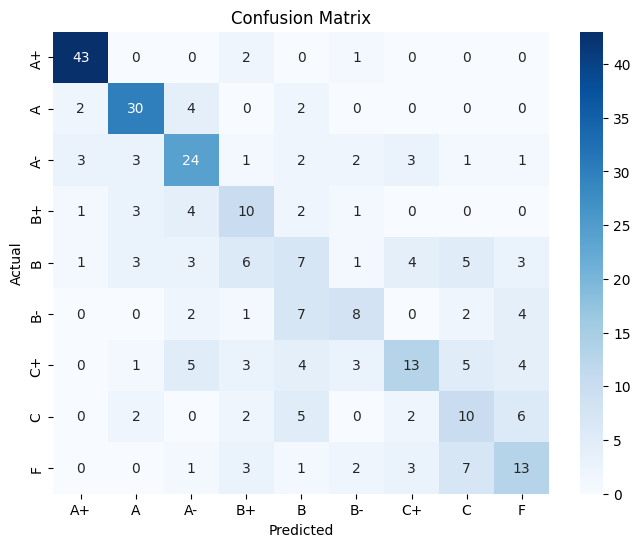

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# =====================
# Fine-Tuning via GridSearchCV with Cross-Validation
# =====================
param_grid = {
    'n_estimators': [100, 300, 700],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt'],
    'class_weight': [class_weights_dict, 'balanced']  # Apply
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(
    max_features='sqrt',
    class_weight=class_weights_dict,
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# =====================
# Evaluate the Fine-Tuned Model on Test Data
# =====================
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Average CV Accuracy:", grid_search.best_score_)
print("Accuracy: ", test_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5247


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-awad_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-awad_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [3 8 0 4 6]


# Software Entrepreneurship

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT",
    "SOFTWARE ENTREPRENEURSHIP"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "SOFTWARE ENTREPRENEURSHIP"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Random Forest

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=11)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'DATABASE SYSTEM FUNDAMENTALS',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY', 'SOFTWARE DESIGN',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Average CV Accuracy: 0.5219090167712654
Accuracy:  0.5185185185185185

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        33
           1       0.85      0.91      0.88        45
           2       0.84      0.98      0.90        43
           3       0.78      0.86      0.82        36
           4       0.71      0.64      0.68        42
           5       0.74      0.49      0.59        41
           6       0.58      0.77      0.66        39
           7       0.37      0.31      0.34        42
           8       0.44      0.40      0.41        43

    accuracy                           0.69       364
   macro avg       0.69      0.70      0.69       364
weighted avg       0.68      0.69      0.68       364



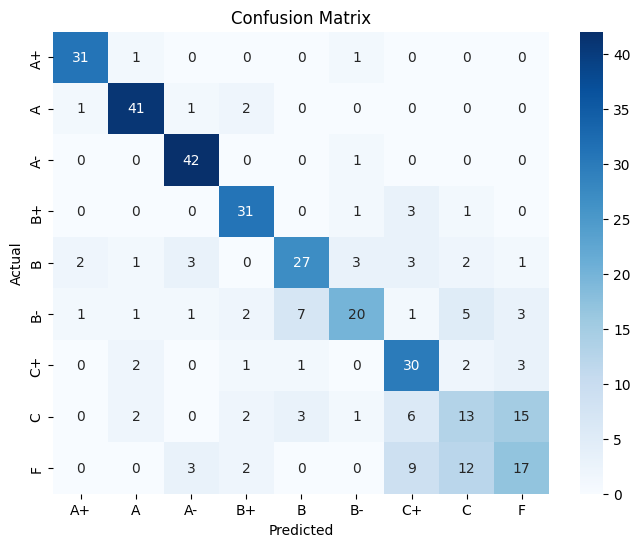

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]

# Compute class weights automatically
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Average CV Accuracy:", grid_search.best_score_)
print("Accuracy: ", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.6818


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-se_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-se_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [6 0 7 7 8]


# Project

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT",
    "SOFTWARE CONSTRUCTION AND CONFIGURATION", "WIRELESS APPLICATION DEVELOPMENT",
    "ADVANCED WEB APPLICATION DEVELOPMENT", "SOFTWARE QUALITY ASSURANCE",
    "SOFTWARE ENTREPRENEURSHIP", "PROJECT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "PROJECT"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=8)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'DATABASE SYSTEM FUNDAMENTALS', 'ADVANCED WEB APPLICATION DEVELOPMENT',
       'SOFTWARE ENTREPRENEURSHIP'],
      dtype='object')


Random Forest Accuracy: 0.5213

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        38
           1       0.68      0.88      0.77        32
           2       0.57      0.79      0.67        34
           3       0.48      0.39      0.43        33
           4       0.46      0.35      0.40        34
           5       0.41      0.26      0.32        27
           6       0.52      0.33      0.41        33
           7       0.23      0.25      0.24        28
           8       0.19      0.26      0.22        23

    accuracy                           0.52       282
   macro avg       0.49      0.50      0.48       282
weighted avg       0.51      0.52      0.51       282



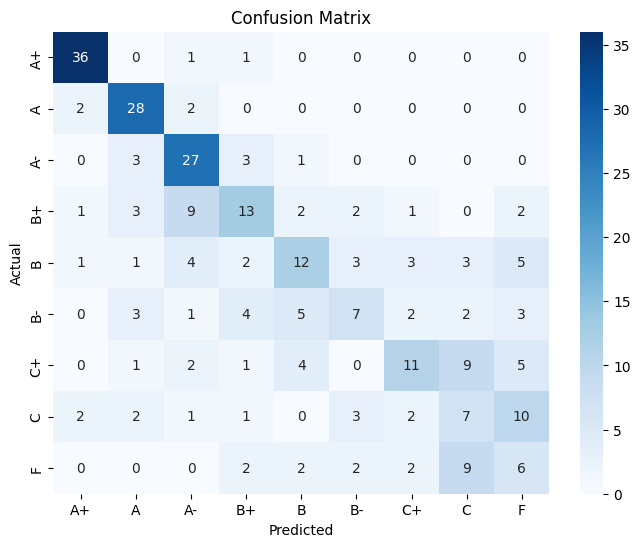

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5079


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-project_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-project_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [1 2 6 3 3]


# Software Quality Assurance

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT",
    "SOFTWARE CONSTRUCTION AND CONFIGURATION", "WIRELESS APPLICATION DEVELOPMENT", "SOFTWARE QUALITY ASSURANCE"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "SOFTWARE QUALITY ASSURANCE"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=11)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'DATABASE SYSTEM FUNDAMENTALS',
       'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY', 'SOFTWARE DESIGN',
       'SOFTWARE PROJECT MANAGEMENT',
       'SOFTWARE CONSTRUCTION AND CONFIGURATION',
       'WIRELESS APPLICATION DEVELOPMENT'],
      dtype='object')


Random Forest Accuracy: 0.6368

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        32
           1       0.73      0.95      0.82        39
           2       0.75      0.94      0.83        47
           3       0.82      0.76      0.79        49
           4       0.63      0.59      0.61        49
           5       0.59      0.63      0.61        46
           6       0.55      0.35      0.43        46
           7       0.36      0.21      0.26        43
           8       0.31      0.38      0.34        29

    accuracy                           0.64       380
   macro avg       0.61      0.64      0.61       380
weighted avg       0.62      0.64      0.62       380



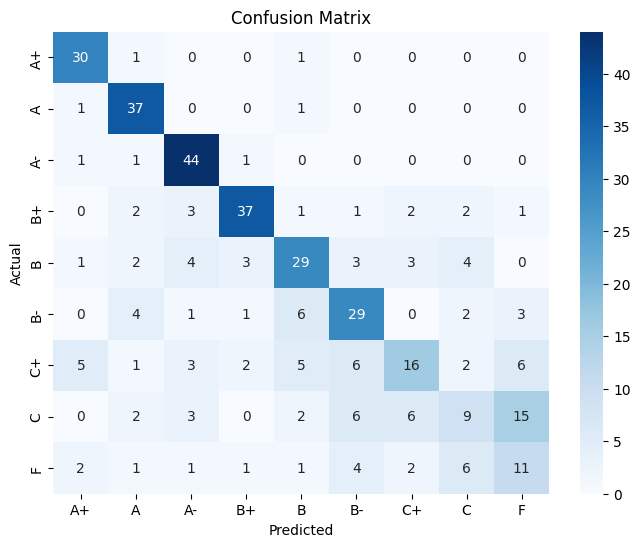

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.6188


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-sqa_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-sqa_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [1 3 5 5 1]


# Wireless Application Development

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "WIRELESS APPLICATION DEVELOPMENT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "WIRELESS APPLICATION DEVELOPMENT"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=14)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY',
       'WEB APPLICATION DEVELOPMENT', 'SOFTWARE DESIGN', 'SOFTWARE TESTING',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5932

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87        34
           1       0.79      0.88      0.84        43
           2       0.70      0.88      0.78        34
           3       0.52      0.53      0.52        30
           4       0.59      0.34      0.43        38
           5       0.20      0.10      0.14        29
           6       0.41      0.43      0.42        28
           7       0.55      0.59      0.57        27
           8       0.39      0.44      0.41        32

    accuracy                           0.59       295
   macro avg       0.55      0.57      0.55       295
weighted avg       0.57      0.59      0.57       295



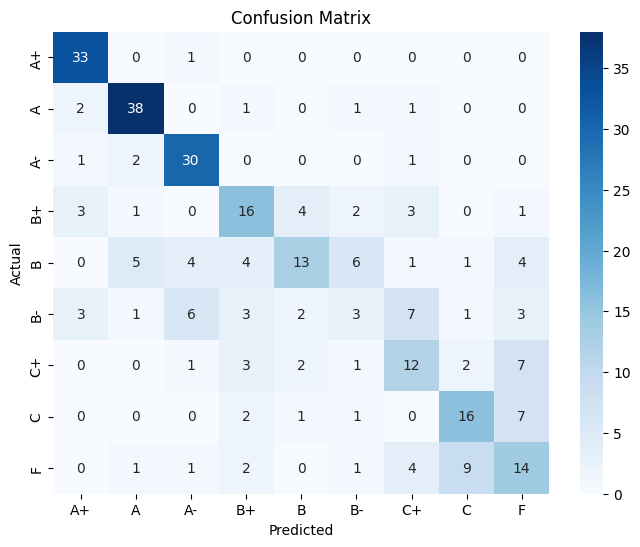

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5711


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-wireless_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-wireless_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [1 6 2 3 7]


# Software Construction and Configuration

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "SOFTWARE CONSTRUCTION AND CONFIGURATION"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "SOFTWARE CONSTRUCTION AND CONFIGURATION"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=11)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS', 'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'HUMAN COMPUTER INTERACTION DESIGN',
       'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY',
       'WEB APPLICATION DEVELOPMENT', 'SOFTWARE DESIGN',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.6178

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       0.82      0.86      0.84        42
           2       0.71      0.88      0.79        40
           3       0.64      0.73      0.68        37
           4       0.62      0.47      0.54        38
           5       0.50      0.45      0.47        31
           6       0.28      0.23      0.25        30
           7       0.29      0.36      0.32        22
           8       0.34      0.29      0.31        35

    accuracy                           0.62       314
   macro avg       0.58      0.59      0.58       314
weighted avg       0.61      0.62      0.61       314



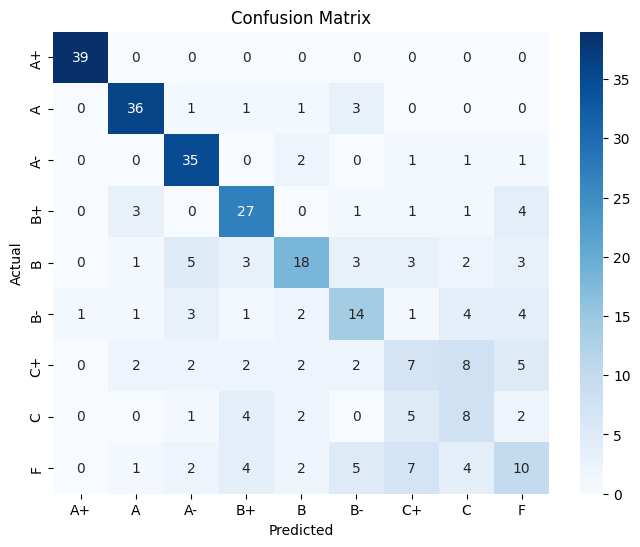

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.6088


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-scc_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-scc_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [4 0 4 0 1]


# Software Project Management

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "SOFTWARE PROJECT MANAGEMENT"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=14)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'OPERATING SYSTEMS', 'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY',
       'WEB APPLICATION DEVELOPMENT', 'SOFTWARE DESIGN', 'SOFTWARE TESTING'],
      dtype='object')


Random Forest Accuracy: 0.6288

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        34
           1       0.80      0.90      0.85        40
           2       0.79      0.88      0.84        43
           3       0.78      0.75      0.77        48
           4       0.59      0.61      0.60        36
           5       0.57      0.36      0.44        44
           6       0.53      0.44      0.48        41
           7       0.41      0.36      0.38        45
           8       0.24      0.37      0.29        30

    accuracy                           0.63       361
   macro avg       0.62      0.63      0.62       361
weighted avg       0.63      0.63      0.62       361



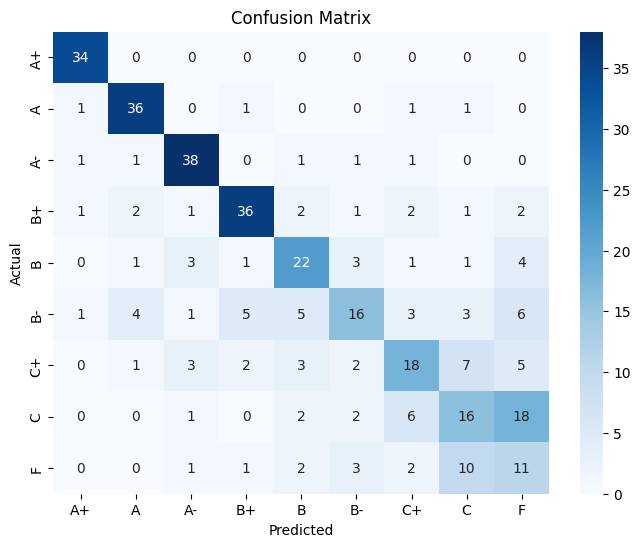

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.6245


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-spm_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-spm_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [7 6 0 2 1]


# Software Testing

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "SOFTWARE TESTING"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "SOFTWARE TESTING"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'DATABASE SYSTEM FUNDAMENTALS', 'OPERATING SYSTEMS',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY'],
      dtype='object')


Random Forest Accuracy: 0.7400

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        47
           1       0.84      0.96      0.90        49
           2       1.00      0.94      0.97        51
           3       0.77      0.81      0.79        58
           4       0.53      0.44      0.48        41
           5       0.76      0.70      0.73        46
           6       0.54      0.54      0.54        46
           7       0.65      0.67      0.66        46
           8       0.49      0.49      0.49        43

    accuracy                           0.74       427
   macro avg       0.73      0.73      0.73       427
weighted avg       0.74      0.74      0.74       427



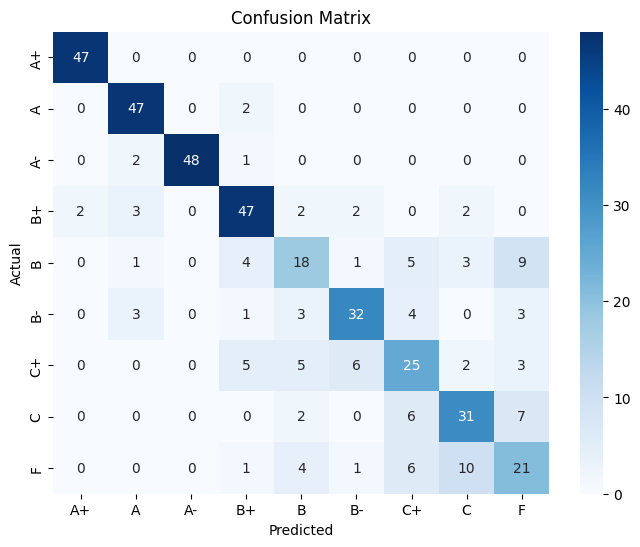

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.7368


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-testing_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-testing_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [4 6 4 3 6]


# Software Design

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "SOFTWARE DESIGN"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "SOFTWARE DESIGN"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=13)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'HUMAN COMPUTER INTERACTION DESIGN', 'OPERATING SYSTEMS',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY'],
      dtype='object')


Random Forest Accuracy: 0.7066

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        43
           1       0.80      0.88      0.84        42
           2       0.93      0.95      0.94        60
           3       0.73      0.75      0.74        44
           4       0.40      0.53      0.45        40
           5       0.71      0.58      0.64        43
           6       0.55      0.52      0.53        33
           7       0.52      0.62      0.56        39
           8       0.71      0.50      0.59        48

    accuracy                           0.71       392
   macro avg       0.70      0.69      0.69       392
weighted avg       0.72      0.71      0.71       392



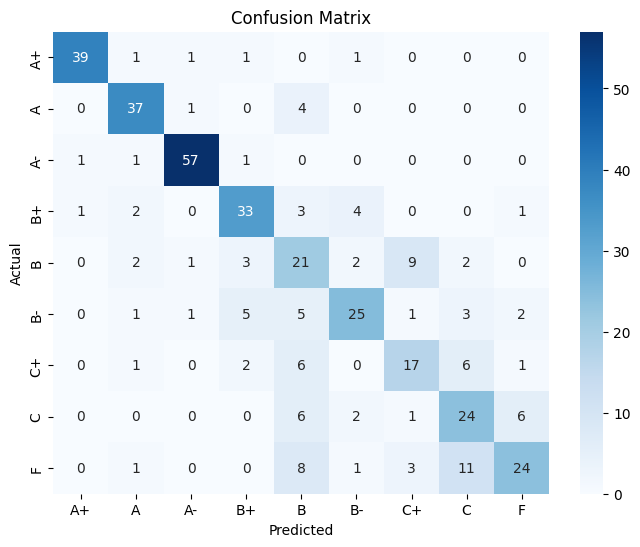

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.7084


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-design_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-design_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [0 7 7 4 2]


# Web Application Development

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "WEB APPLICATION DEVELOPMENT"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=11)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'OPERATING SYSTEMS',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY'],
      dtype='object')


Random Forest Accuracy: 0.7059

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       0.82      0.90      0.86        41
           2       0.94      0.92      0.93        49
           3       0.79      0.84      0.81        44
           4       0.43      0.56      0.49        41
           5       0.70      0.60      0.65        50
           6       0.58      0.49      0.53        39
           7       0.59      0.52      0.55        46
           8       0.53      0.51      0.52        41

    accuracy                           0.71       391
   macro avg       0.70      0.70      0.70       391
weighted avg       0.71      0.71      0.70       391



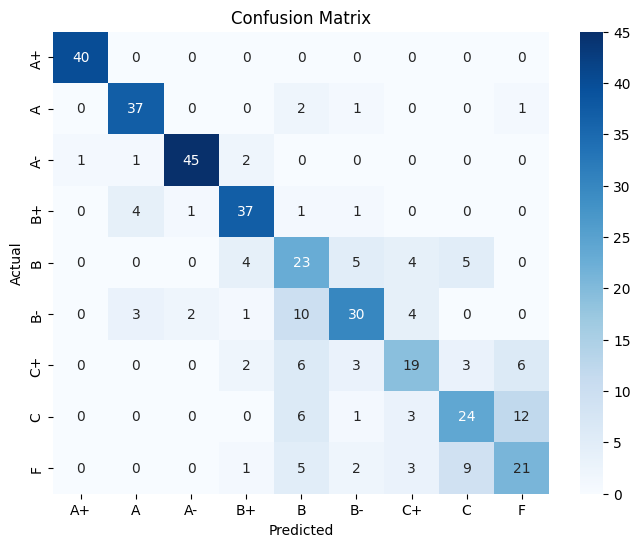

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.7048


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-wad_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-wad_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [3 5 0 0 8]


# Computer Ethics and Professional Responsibility

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(smote=SMOTE(k_neighbors=2), random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=12)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS', 'HUMAN COMPUTER INTERACTION DESIGN',
       'WEB APPLICATION DEVELOPMENT', 'SOFTWARE DESIGN', 'SOFTWARE TESTING',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.8529

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        65
           1       0.94      0.98      0.96        64
           2       0.97      0.98      0.98        63
           3       0.98      0.95      0.97        64
           4       0.76      0.81      0.78        67
           5       0.84      0.97      0.90        69
           6       0.82      0.72      0.76        81
           7       0.65      0.64      0.64        69
           8       0.76      0.69      0.72        70

    accuracy                           0.85       612
   macro avg       0.86      0.86      0.86       612
weighted avg       0.85      0.85      0.85       612



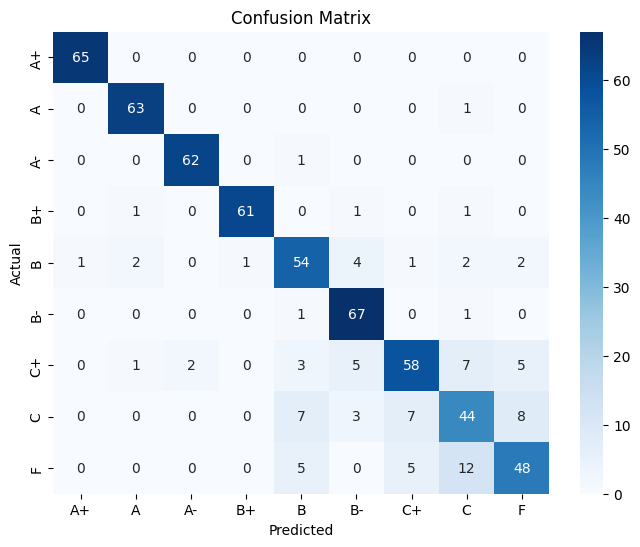

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.8508


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-ethics_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-ethics_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [2 1 1 1 1]


# Problem Solving with Data Structures and Algorithms

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'OPERATING SYSTEMS', 'WEB APPLICATION DEVELOPMENT', 'SOFTWARE TESTING',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.7449

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        56
           1       0.89      0.92      0.91        63
           2       0.96      1.00      0.98        54
           3       0.80      0.67      0.73        49
           4       0.61      0.53      0.57        66
           5       0.66      0.70      0.68        44
           6       0.53      0.60      0.56        52
           7       0.67      0.64      0.65        58
           8       0.61      0.63      0.62        52

    accuracy                           0.74       494
   macro avg       0.74      0.74      0.74       494
weighted avg       0.74      0.74      0.74       494



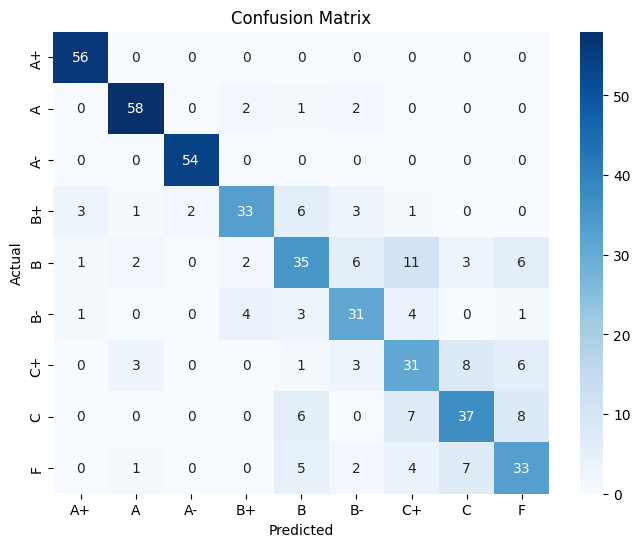

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.7426


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-algo_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-algo_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [5 2 2 3 1]


# Operating Systems

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "OPERATING SYSTEMS"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(smote=SMOTE(k_neighbors=2), random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=8)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'HUMAN COMPUTER INTERACTION DESIGN',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'WEB APPLICATION DEVELOPMENT', 'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.8090

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       0.99      0.99      0.99        74
           2       0.96      0.98      0.97        56
           3       0.90      0.92      0.91        71
           4       0.77      0.74      0.76        74
           5       0.82      0.84      0.83        64
           6       0.70      0.53      0.60        80
           7       0.68      0.72      0.70        82
           8       0.53      0.64      0.58        69

    accuracy                           0.81       644
   macro avg       0.82      0.82      0.82       644
weighted avg       0.81      0.81      0.81       644



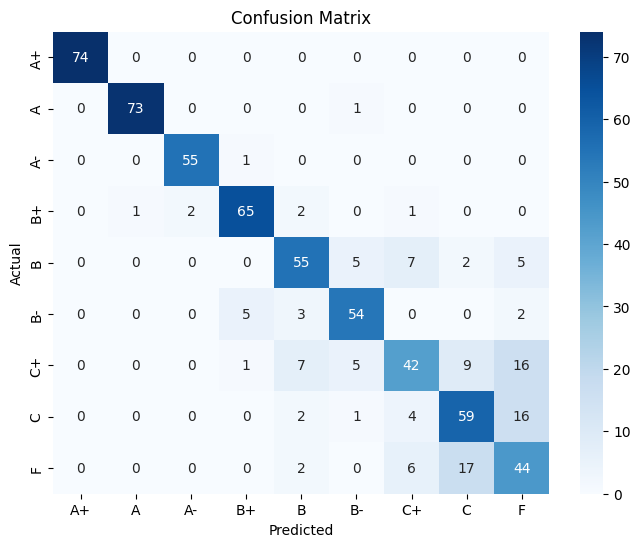

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.8083


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-os_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-os_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [7 7 8 3 1]


# Human Computer Interaction Design

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "HUMAN COMPUTER INTERACTION DESIGN"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(smote=SMOTE(k_neighbors=2), random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=11)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'OPERATING SYSTEMS',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY', 'SOFTWARE DESIGN',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.8857

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        70
           1       0.99      1.00      0.99        79
           2       0.99      0.99      0.99        81
           3       0.96      0.95      0.96        79
           4       0.79      0.83      0.81        83
           5       0.85      0.91      0.88        74
           6       0.86      0.74      0.79        80
           7       0.72      0.79      0.75        75
           8       0.85      0.79      0.81        70

    accuracy                           0.89       691
   macro avg       0.89      0.89      0.89       691
weighted avg       0.89      0.89      0.89       691



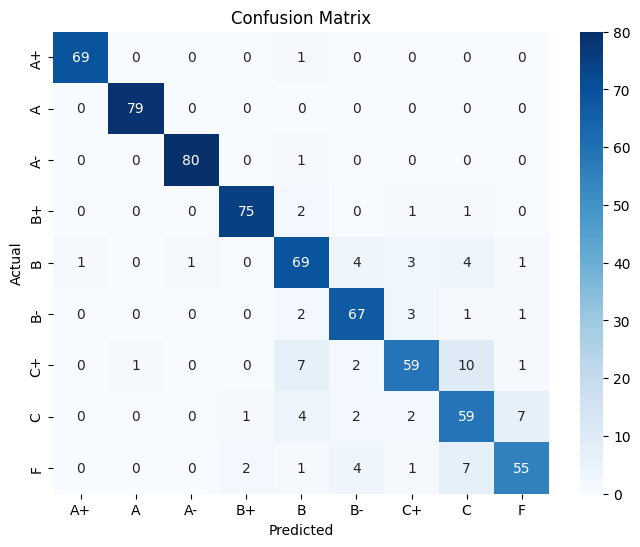

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.8856


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-hcid_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-hcid_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [3 1 2 7 8]


# Introduction to Computer Organisation and Architecture

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=12)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS', 'HUMAN COMPUTER INTERACTION DESIGN',
       'OPERATING SYSTEMS',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY'],
      dtype='object')


Random Forest Accuracy: 0.7870

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        47
           1       0.86      0.96      0.91        52
           2       0.93      1.00      0.96        53
           3       0.74      0.83      0.78        52
           4       0.70      0.65      0.67        48
           5       0.95      0.71      0.81        49
           6       0.67      0.64      0.65        50
           7       0.69      0.63      0.66        43
           8       0.60      0.65      0.62        52

    accuracy                           0.79       446
   macro avg       0.79      0.78      0.78       446
weighted avg       0.79      0.79      0.79       446



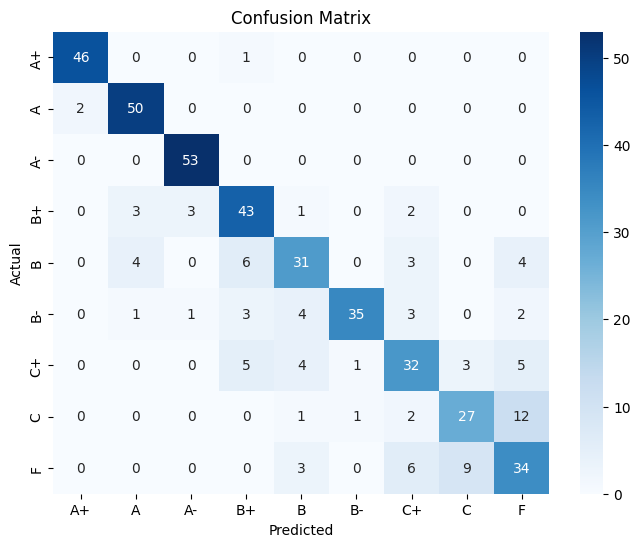

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.7851


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-coa_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-coa_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [7 5 3 7 3]


# Database System Fundamentals

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "DATABASE SYSTEM FUNDAMENTALS"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=8)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY'],
      dtype='object')


Random Forest Accuracy: 0.5847

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        43
           1       0.65      0.56      0.60        36
           2       0.66      0.94      0.78        35
           3       0.57      0.41      0.47        32
           4       0.18      0.10      0.12        31
           5       0.22      0.13      0.17        30
           6       0.46      0.39      0.43        33
           7       0.70      0.97      0.81        31
           8       0.58      0.70      0.64        30

    accuracy                           0.58       301
   macro avg       0.52      0.57      0.53       301
weighted avg       0.54      0.58      0.55       301



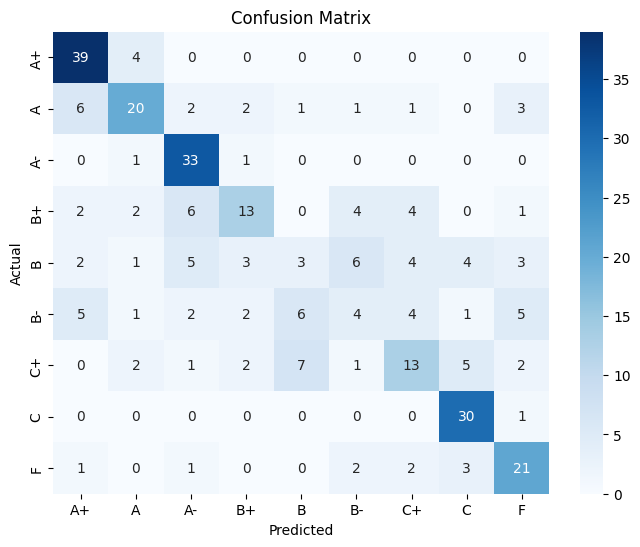

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5488


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-database_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-database_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [2 0 6 1 8]


# Object-Oriented Application Development

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "OBJECT-ORIENTED APPLICATION DEVELOPMENT"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=7)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'DATABASE SYSTEM FUNDAMENTALS'],
      dtype='object')


Random Forest Accuracy: 0.5447

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        23
           1       0.81      0.55      0.66        40
           2       0.75      0.87      0.81        31
           3       0.36      0.58      0.44        24
           4       0.17      0.17      0.17        23
           5       0.41      0.22      0.29        32
           6       0.43      0.36      0.39        28
           7       0.50      0.70      0.58        27
           8       0.58      0.52      0.55        29

    accuracy                           0.54       257
   macro avg       0.54      0.55      0.53       257
weighted avg       0.55      0.54      0.54       257



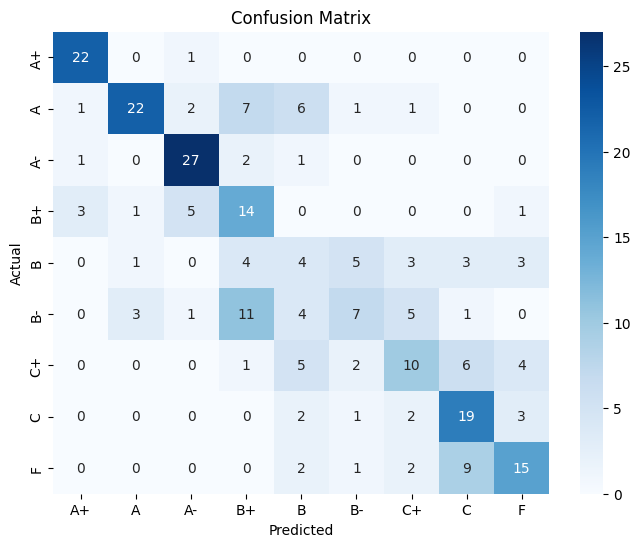

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5362


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-ooad_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-ooad_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [6 7 7 1 5]


# Probability and Statistics for Computing

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "PROBABILITY AND STATISTICS FOR COMPUTING"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=7)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS'],
      dtype='object')


Random Forest Accuracy: 0.6078

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81        31
           1       0.68      0.68      0.68        41
           2       0.78      0.84      0.81        43
           3       0.64      0.50      0.56        28
           4       0.39      0.30      0.34        30
           5       0.41      0.42      0.42        26
           6       0.32      0.32      0.32        22
           7       0.63      0.65      0.64        34
           8       0.58      0.64      0.61        28

    accuracy                           0.61       283
   macro avg       0.58      0.58      0.58       283
weighted avg       0.60      0.61      0.60       283



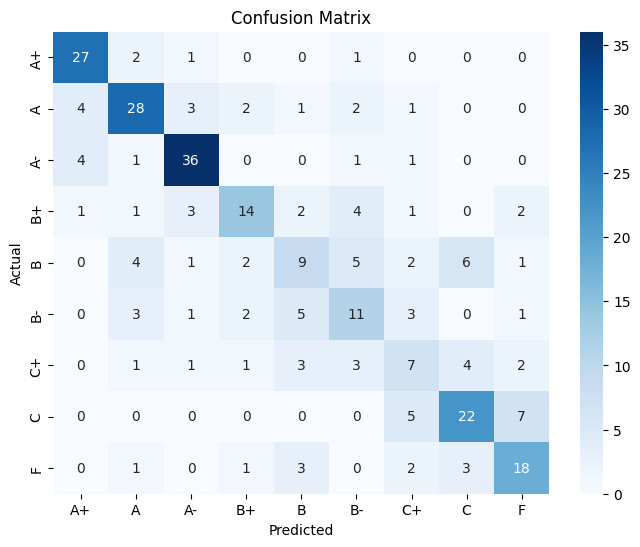

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.6014


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-prob_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-prob_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [3 0 1 5 5]


# TCP/IP Network Fundamentals

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "TCP/IP NETWORK FUNDAMENTALS"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=7)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS'],
      dtype='object')


Random Forest Accuracy: 0.5951

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.85      0.79        39
           1       0.67      0.73      0.70        30
           2       0.69      0.65      0.67        37
           3       0.56      0.58      0.57        31
           4       0.46      0.34      0.39        32
           5       0.39      0.47      0.43        19
           6       0.50      0.64      0.56        28
           7       0.73      0.46      0.56        35
           8       0.53      0.55      0.54        33

    accuracy                           0.60       284
   macro avg       0.58      0.59      0.58       284
weighted avg       0.60      0.60      0.59       284



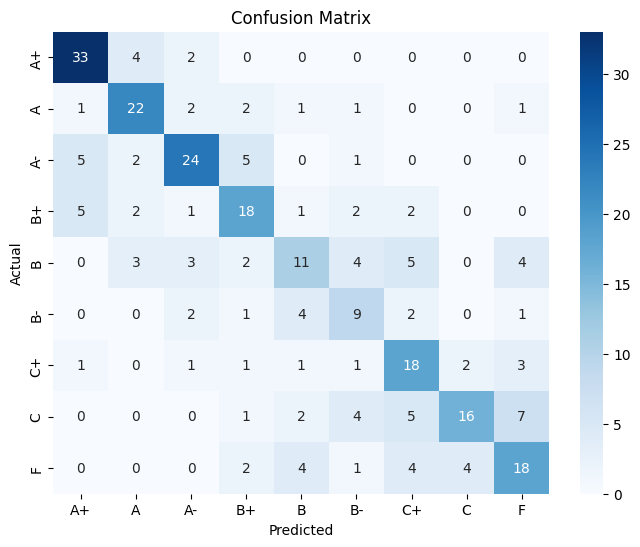

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5909


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-tcpip-fundamentals_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-tcpip-fundamentals_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [8 4 5 4 8]


# Software and Requirements

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "SOFTWARE AND REQUIREMENTS"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=7)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS'],
      dtype='object')


Random Forest Accuracy: 0.7064

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        40
           1       0.81      0.76      0.79        34
           2       0.90      0.96      0.93        47
           3       0.75      0.82      0.78        44
           4       0.62      0.53      0.57        40
           5       0.61      0.70      0.65        40
           6       0.54      0.50      0.52        38
           7       0.51      0.55      0.53        33
           8       0.62      0.51      0.56        45

    accuracy                           0.71       361
   macro avg       0.69      0.70      0.70       361
weighted avg       0.70      0.71      0.70       361



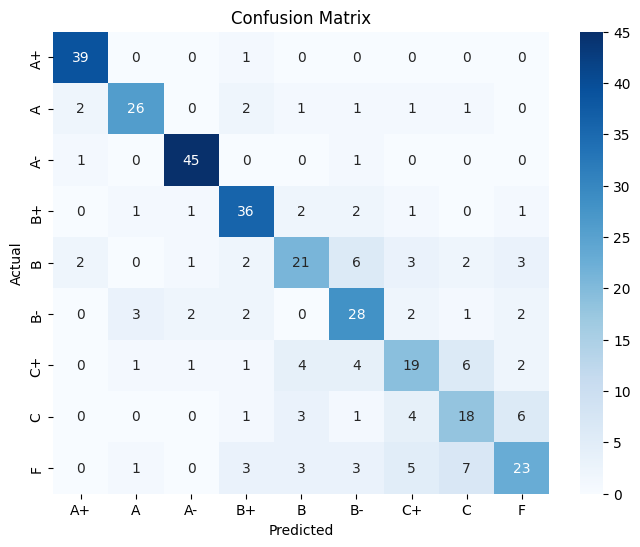

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.7014


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-requirements_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-requirements_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [6 7 0 3 2]


# Programming and Problem Solving

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "PROGRAMMING AND PROBLEM SOLVING"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS'],
      dtype='object')


Random Forest Accuracy: 0.5865

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        36
           1       0.67      0.68      0.67        41
           2       0.78      0.88      0.83        33
           3       0.64      0.51      0.57        35
           4       0.33      0.18      0.23        28
           5       0.20      0.40      0.27        15
           6       0.31      0.32      0.32        28
           7       0.65      0.50      0.57        30
           8       0.48      0.55      0.51        20

    accuracy                           0.59       266
   macro avg       0.55      0.56      0.54       266
weighted avg       0.59      0.59      0.58       266



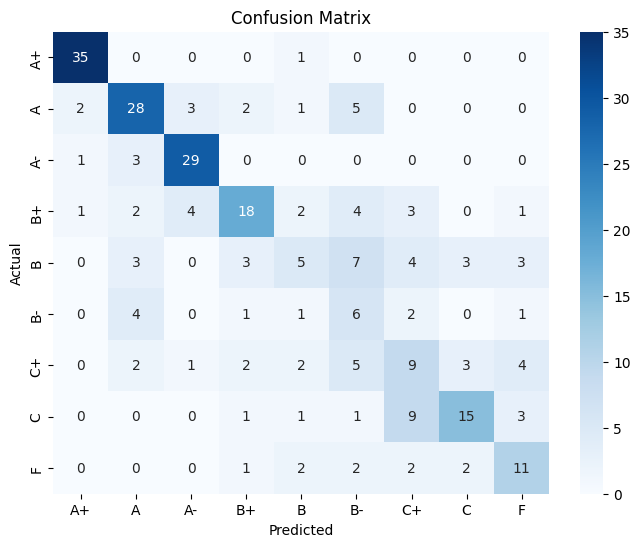

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5834


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-programming_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-programming_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [0 8 0 4 8]


# Multimedia Technology

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "MULTIMEDIA TECHNOLOGY"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "MULTIMEDIA TECHNOLOGY"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=9)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week', 'SOFTWARE AND REQUIREMENTS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY', 'SOFTWARE DESIGN',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.6040

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        40
           1       0.78      0.89      0.83        47
           2       0.75      0.75      0.75        36
           3       0.57      0.69      0.63        39
           4       0.47      0.50      0.49        36
           5       0.62      0.36      0.45        45
           6       0.55      0.49      0.52        45
           7       0.31      0.30      0.31        33
           8       0.33      0.33      0.33        30

    accuracy                           0.60       351
   macro avg       0.58      0.59      0.58       351
weighted avg       0.60      0.60      0.59       351



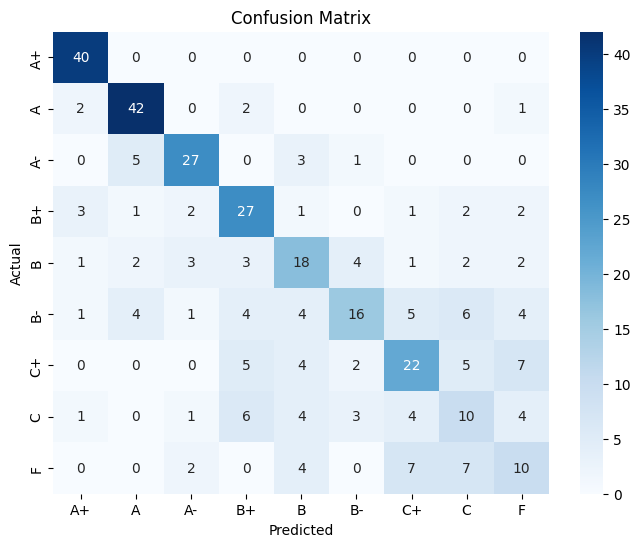

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5931


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-multimedia_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-multimedia_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [6 3 5 3 3]


# Artificial Intelligence

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "ARTIFICIAL INTELLIGENCE"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "ARTIFICIAL INTELLIGENCE"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'SOFTWARE DESIGN', 'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.6051

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        42
           1       0.76      1.00      0.86        34
           2       0.68      0.65      0.67        43
           3       0.75      0.60      0.67        35
           4       0.49      0.67      0.56        33
           5       0.55      0.43      0.48        28
           6       0.56      0.42      0.48        43
           7       0.06      0.04      0.05        26
           8       0.41      0.50      0.45        30

    accuracy                           0.61       314
   macro avg       0.56      0.58      0.56       314
weighted avg       0.59      0.61      0.59       314



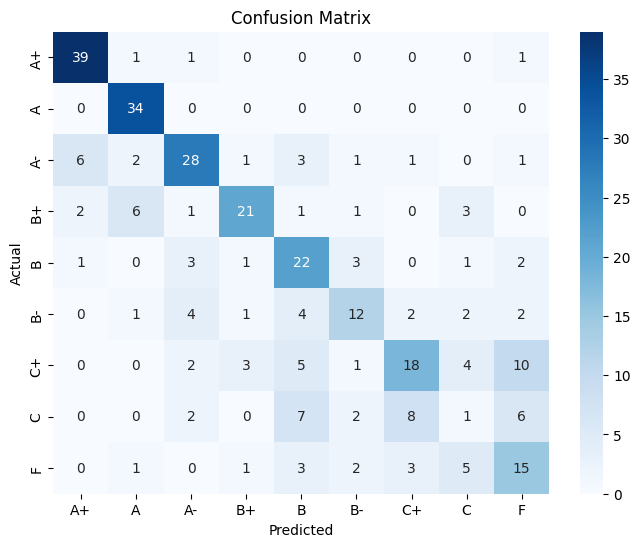

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5893


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-ai_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-ai_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [8 1 3 3 0]


# Team Project

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "TEAM PROJECT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "TEAM PROJECT"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=12)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY',
       'WEB APPLICATION DEVELOPMENT', 'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5765

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        33
           1       0.82      0.84      0.83        44
           2       0.77      0.84      0.81        32
           3       0.64      0.56      0.60        32
           4       0.48      0.46      0.47        28
           5       0.52      0.37      0.43        43
           6       0.35      0.41      0.38        29
           7       0.27      0.26      0.26        31
           8       0.40      0.40      0.40        35

    accuracy                           0.58       307
   macro avg       0.56      0.57      0.56       307
weighted avg       0.57      0.58      0.57       307



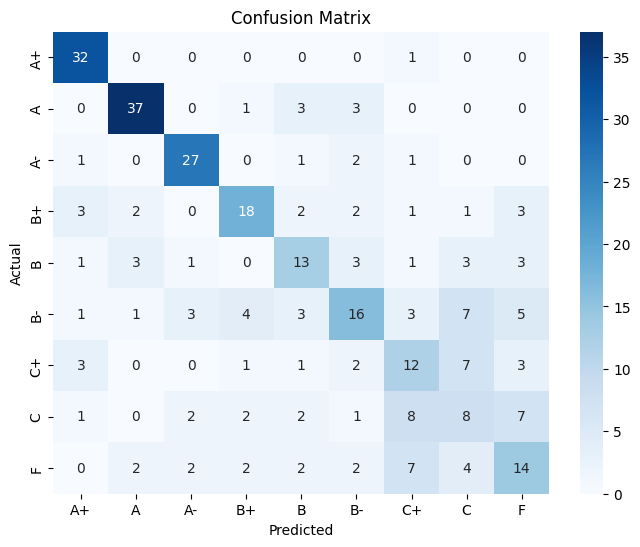

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5692


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-team-project_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-team-project_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [2 0 5 1 7]


# Programming with Game Engines

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "PROGRAMMING WITH GAME ENGINES"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "PROGRAMMING WITH GAME ENGINES"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=8)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'DATABASE SYSTEM FUNDAMENTALS',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'SOFTWARE DESIGN', 'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5222

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87        41
           1       0.72      0.77      0.74        43
           2       0.68      0.66      0.67        38
           3       0.59      0.55      0.57        31
           4       0.28      0.29      0.29        24
           5       0.31      0.30      0.30        27
           6       0.32      0.30      0.31        27
           7       0.31      0.26      0.28        31
           8       0.25      0.23      0.24        31

    accuracy                           0.52       293
   macro avg       0.47      0.48      0.47       293
weighted avg       0.50      0.52      0.51       293



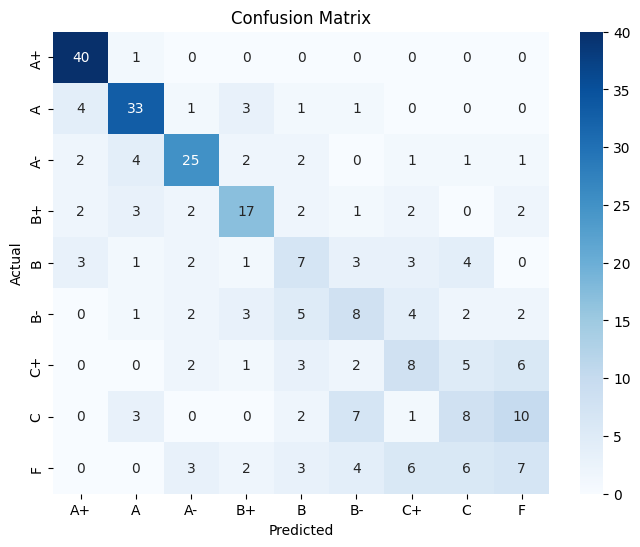

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5113


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-game-engines_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-game-engines_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [2 7 7 7 2]


# Advanced Database Systems

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "ADVANCED DATABASE SYSTEMS"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "ADVANCED DATABASE SYSTEMS"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=9)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'TCP/IP NETWORK FUNDAMENTALS',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'SOFTWARE DESIGN', 'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5167

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       0.59      0.67      0.62        30
           2       0.68      0.78      0.72        32
           3       0.50      0.52      0.51        29
           4       0.39      0.31      0.35        29
           5       0.25      0.30      0.27        27
           6       0.52      0.43      0.47        37
           7       0.29      0.28      0.28        29
           8       0.35      0.31      0.33        26

    accuracy                           0.52       269
   macro avg       0.50      0.51      0.50       269
weighted avg       0.51      0.52      0.51       269



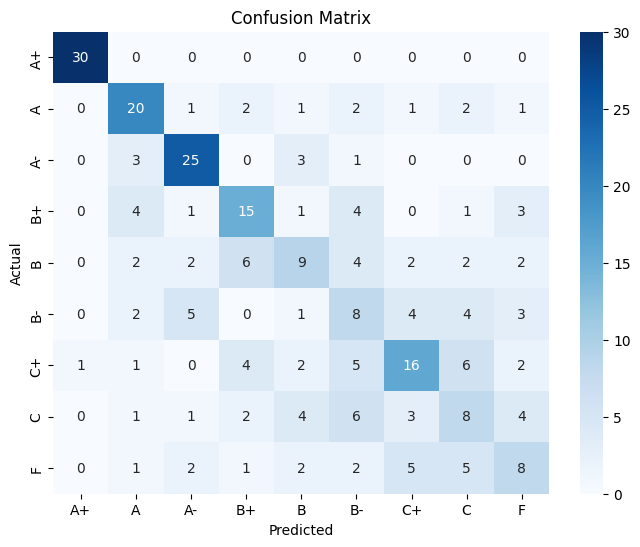

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5115


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-advanced-database_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-advanced-database_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [7 8 1 5 0]


# Cloud Computing

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "CLOUD COMPUTING"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "CLOUD COMPUTING"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=9)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'DATABASE SYSTEM FUNDAMENTALS',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'WEB APPLICATION DEVELOPMENT', 'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5172

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89        30
           1       0.73      0.75      0.74        32
           2       0.62      0.69      0.65        26
           3       0.53      0.62      0.57        29
           4       0.31      0.17      0.22        29
           5       0.07      0.11      0.09        18
           6       0.43      0.50      0.46        30
           7       0.41      0.23      0.30        39
           8       0.52      0.54      0.53        28

    accuracy                           0.52       261
   macro avg       0.49      0.51      0.49       261
weighted avg       0.51      0.52      0.51       261



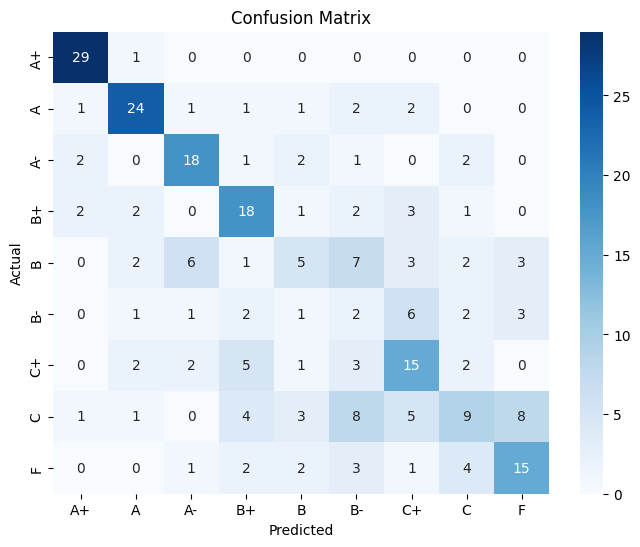

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5061


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-cloud-computing_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-cloud-computing_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [2 0 7 0 2]


# Digital Image Processing

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "DIGITAL IMAGE PROCESSING"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "DIGITAL IMAGE PROCESSING"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=9)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS', 'WEB APPLICATION DEVELOPMENT',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5281

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.95      0.82        42
           1       0.67      0.56      0.61        39
           2       0.62      0.81      0.71        37
           3       0.71      0.61      0.66        36
           4       0.50      0.32      0.39        34
           5       0.26      0.29      0.27        28
           6       0.31      0.28      0.29        29
           7       0.29      0.27      0.28        26
           8       0.38      0.38      0.38        32

    accuracy                           0.53       303
   macro avg       0.49      0.50      0.49       303
weighted avg       0.52      0.53      0.52       303



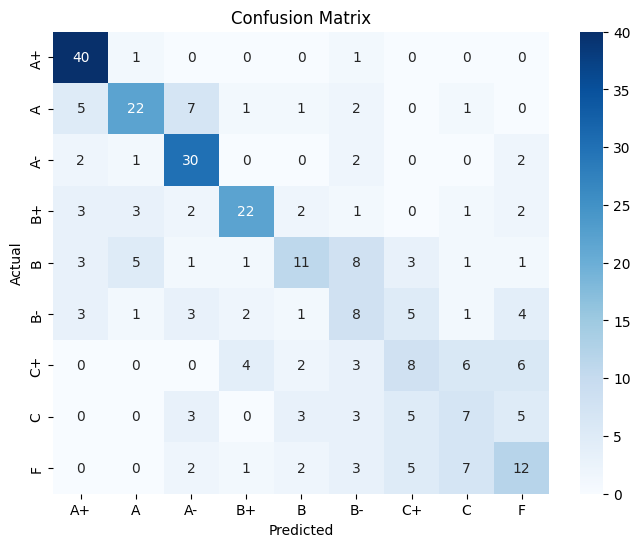

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5167


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-dip_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-dip_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [2 8 3 5 8]


# Fundamentals of Cybersecurity

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "FUNDAMENTALS OF CYBERSECURITY"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "FUNDAMENTALS OF CYBERSECURITY"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=9)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5160

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        36
           1       0.82      0.72      0.77        32
           2       0.57      0.73      0.64        22
           3       0.52      0.54      0.53        26
           4       0.19      0.17      0.18        18
           5       0.39      0.28      0.33        25
           6       0.39      0.32      0.35        34
           7       0.32      0.36      0.34        28
           8       0.35      0.41      0.38        29

    accuracy                           0.52       250
   macro avg       0.49      0.49      0.49       250
weighted avg       0.51      0.52      0.51       250



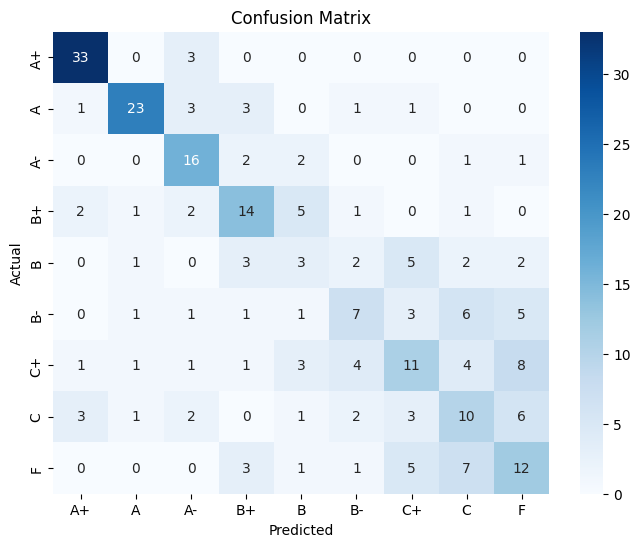

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5101


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-cybersecurity_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-cybersecurity_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [8 2 0 2 5]


# Parallel Processing

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "PARALLEL PROCESSING"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "PARALLEL PROCESSING"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=11)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5500

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        33
           1       0.91      0.81      0.85        36
           2       0.47      0.86      0.61        21
           3       0.59      0.56      0.58        34
           4       0.41      0.30      0.35        30
           5       0.53      0.24      0.33        37
           6       0.48      0.50      0.49        32
           7       0.35      0.32      0.33        28
           8       0.33      0.41      0.37        29

    accuracy                           0.55       280
   macro avg       0.54      0.56      0.53       280
weighted avg       0.55      0.55      0.54       280



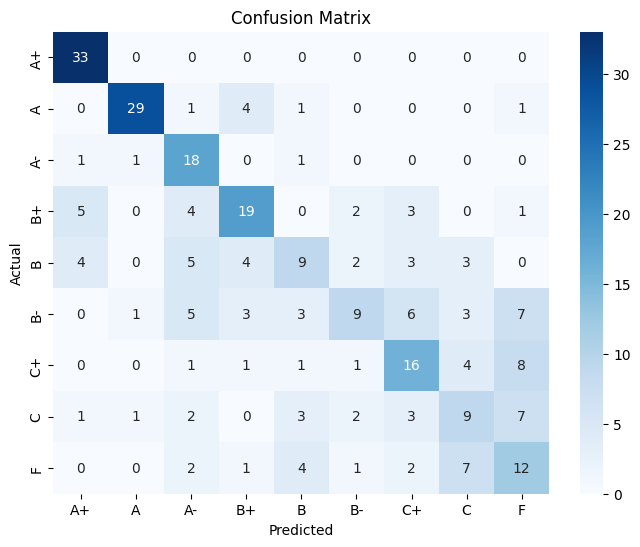

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5353


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-parallel-processing_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-parallel-processing_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [8 0 4 7 6]


# Data Mining

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "DATA MINING"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "DATA MINING"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5801

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        39
           1       0.72      0.94      0.82        36
           2       0.57      0.75      0.65        32
           3       0.69      0.66      0.68        38
           4       0.48      0.46      0.47        35
           5       0.59      0.50      0.54        34
           6       0.42      0.44      0.43        39
           7       0.38      0.28      0.33        46
           8       0.44      0.44      0.44        32

    accuracy                           0.58       331
   macro avg       0.57      0.59      0.58       331
weighted avg       0.57      0.58      0.57       331



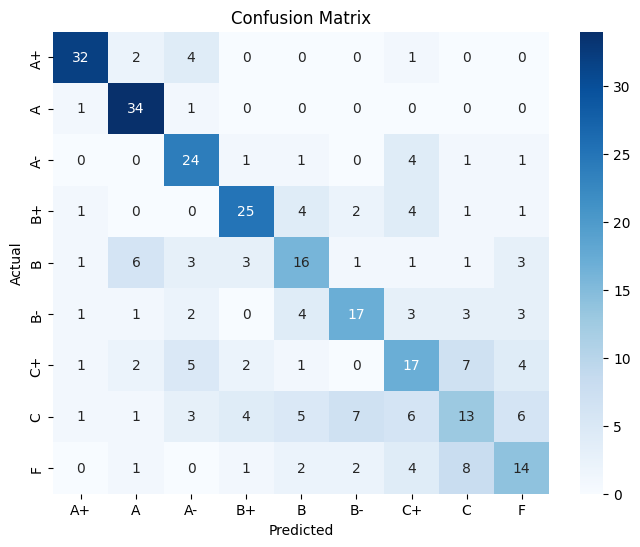

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5707


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-dm_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-dm_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [7 3 6 0 1]


# TCP/IP Network Routing

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "TCP/IP NETWORK ROUTING"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "TCP/IP NETWORK ROUTING"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=12)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'WEB APPLICATION DEVELOPMENT', 'SOFTWARE TESTING',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5190

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        32
           1       0.84      0.87      0.86        31
           2       0.64      0.62      0.63        40
           3       0.50      0.42      0.46        31
           4       0.20      0.28      0.23        25
           5       0.57      0.38      0.46        34
           6       0.41      0.43      0.42        30
           7       0.34      0.33      0.34        36
           8       0.32      0.27      0.29        30

    accuracy                           0.52       289
   macro avg       0.51      0.51      0.51       289
weighted avg       0.52      0.52      0.51       289



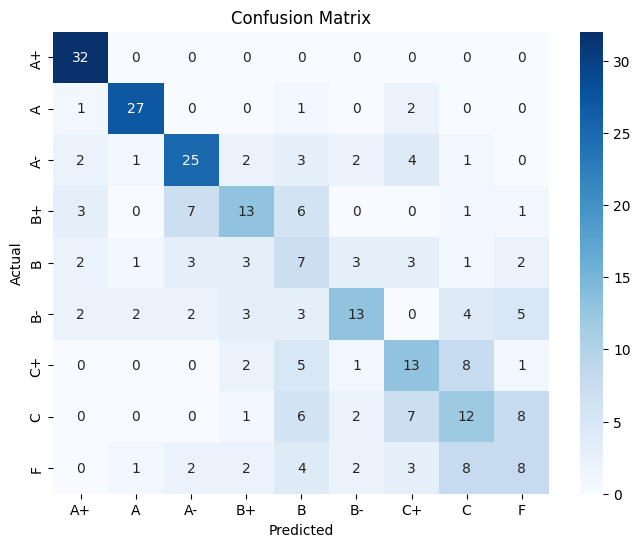

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5139


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-tcpip-routing_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-tcpip-routing_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [8 7 0 7 0]


# Server Configuration and Management

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "SERVER CONFIGURATION AND MANAGEMENT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "SERVER CONFIGURATION AND MANAGEMENT"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=12)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS',
       'INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE',
       'PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS',
       'WEB APPLICATION DEVELOPMENT', 'SOFTWARE DESIGN',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5329

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        31
           1       0.60      0.79      0.68        34
           2       0.74      0.68      0.70        37
           3       0.71      0.71      0.71        28
           4       0.23      0.26      0.25        27
           5       0.48      0.41      0.44        34
           6       0.32      0.33      0.33        27
           7       0.32      0.21      0.25        29
           8       0.46      0.40      0.43        42

    accuracy                           0.53       289
   macro avg       0.51      0.53      0.51       289
weighted avg       0.52      0.53      0.52       289



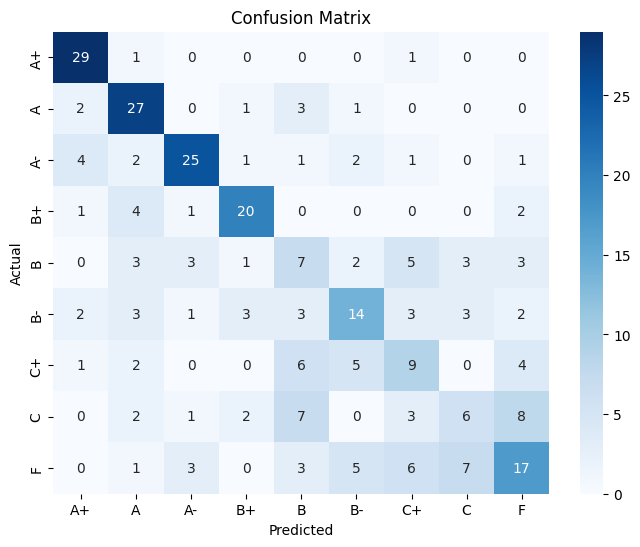

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.5221


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-scm_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-scm_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [6 6 0 1 0]


# TCP/IP Network Application Development

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "TCP/IP NETWORK APPLICATION DEVELOPMENT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "TCP/IP NETWORK APPLICATION DEVELOPMENT"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=11)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'PROBABILITY AND STATISTICS FOR COMPUTING',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS', 'SOFTWARE DESIGN', 'SOFTWARE TESTING',
       'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81        30
           1       0.70      0.85      0.77        33
           2       0.58      0.76      0.66        33
           3       0.56      0.66      0.61        35
           4       0.28      0.15      0.20        33
           5       0.47      0.17      0.25        42
           6       0.27      0.31      0.29        26
           7       0.06      0.05      0.06        19
           8       0.38      0.52      0.44        25

    accuracy                           0.50       276
   macro avg       0.45      0.49      0.45       276
weighted avg       0.47      0.50      0.47       276



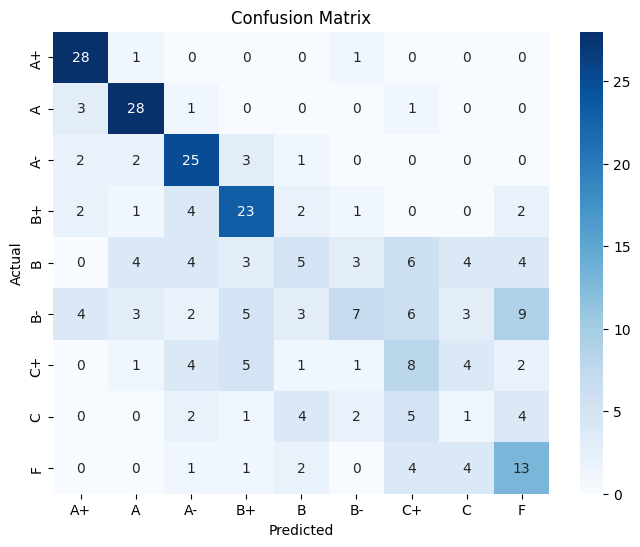

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.4669


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-network-application_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-network-application_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [1 1 2 5 0]


# Network Security Management

In [ ]:
columns = ['CGPA', 'Average Studying Hours per Week',
    "PROGRAMMING AND PROBLEM SOLVING", "SOFTWARE AND REQUIREMENTS",
    "TCP/IP NETWORK FUNDAMENTALS", "PROBABILITY AND STATISTICS FOR COMPUTING",
    "OBJECT-ORIENTED APPLICATION DEVELOPMENT", "DATABASE SYSTEM FUNDAMENTALS",
    "INTRODUCTION TO COMPUTER ORGANISATION AND ARCHITECTURE", "HUMAN COMPUTER INTERACTION DESIGN",
    "OPERATING SYSTEMS", "PROBLEM SOLVING WITH DATA STRUCTURES AND ALGORITHMS",
    "COMPUTER ETHICS AND PROFESSIONAL RESPONSIBILITY", "WEB APPLICATION DEVELOPMENT",
    "SOFTWARE DESIGN", "SOFTWARE TESTING", "SOFTWARE PROJECT MANAGEMENT", "NETWORK SECURITY MANAGEMENT"]
df_filtered = df[columns]

# =====================
# Define Features & Target
# =====================
target_subject = "NETWORK SECURITY MANAGEMENT"

X = df_filtered.drop(columns=[target_subject])  # Features (all except AWAD grade)
y = df_filtered[target_subject]  # Target (AWAD grade)

# =====================
# Handle Imbalanced Data
# =====================
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# =====================
# Train Random Forest Model (with Hyperparameter Tuning)
# =====================
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features_rfe = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# Display selected features
print("Selected Features via RFE:\n", selected_features_rfe)

Selected Features via RFE:
 Index(['CGPA', 'Average Studying Hours per Week',
       'PROGRAMMING AND PROBLEM SOLVING', 'SOFTWARE AND REQUIREMENTS',
       'TCP/IP NETWORK FUNDAMENTALS',
       'OBJECT-ORIENTED APPLICATION DEVELOPMENT',
       'DATABASE SYSTEM FUNDAMENTALS', 'HUMAN COMPUTER INTERACTION DESIGN',
       'WEB APPLICATION DEVELOPMENT', 'SOFTWARE PROJECT MANAGEMENT'],
      dtype='object')


Random Forest Accuracy: 0.5124

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89        35
           1       0.52      0.69      0.59        35
           2       0.62      0.54      0.58        39
           3       0.30      0.46      0.36        24
           4       0.27      0.11      0.16        36
           5       0.52      0.33      0.41        33
           6       0.53      0.58      0.55        33
           7       0.32      0.30      0.31        23
           8       0.45      0.56      0.50        25

    accuracy                           0.51       283
   macro avg       0.48      0.50      0.48       283
weighted avg       0.50      0.51      0.49       283



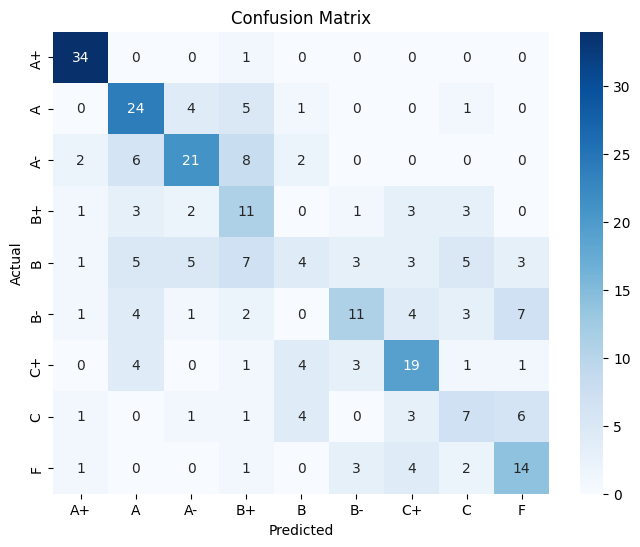

In [ ]:
X_train = X_train[selected_features_rfe]
X_test = X_test[selected_features_rfe]
# =====================
# Compute Class Weights (based on training data)
# =====================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Apply weights to the model
best_model = RandomForestClassifier(
      n_estimators=700,
      max_depth=20,
      min_samples_split=2,
      max_features='sqrt',
      class_weight=class_weights_dict,  # Apply weight adjustment
      random_state=42,
      n_jobs=-1
)

# Retrain with selected features
best_model.fit(X_train, y_train)

# =====================
# Evaluate Model
# =====================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Avoid undefined metric warning

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=grade_map.keys(), yticklabels=grade_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Weighted F1 Score: 0.4950


In [ ]:
# Save the trained model
joblib.dump(best_model, "rf-network-security_9.pkl")

# Load the saved model
loaded_model = joblib.load("rf-network-security_9.pkl")
print("✅ Model loaded successfully!")

# Example: Make predictions on new data
new_data = X_test.iloc[:5]  # Replace with real new data
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

✅ Model loaded successfully!
Predictions: [6 0 4 2 7]
